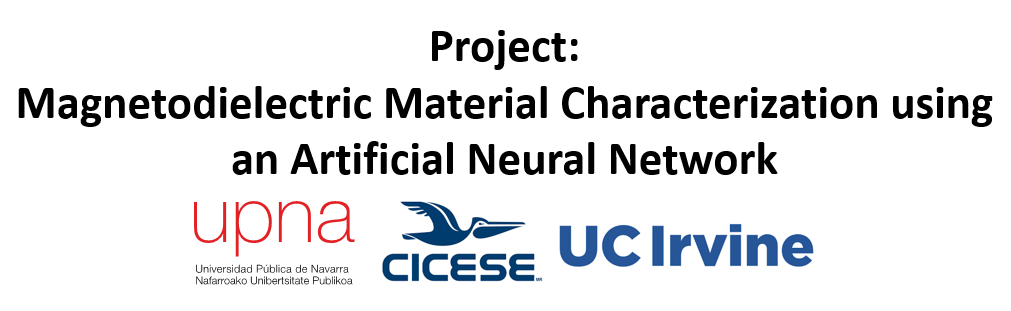


**Autors:**  
G. Álvarez-Botero<sup>1</sup>, N. Duque-Madrid<sup>1</sup>, H. Lobato-Morales<sup>2</sup>, G. Méndez-Jerónimo<sup>2</sup>, K. Hui<sup>3</sup>, 
N. Tarabay<sup>3</sup>, A. Pons-Abenza<sup>1</sup>, I. Arregui<sup>1</sup>, T. Lopetegi<sup>1</sup>, M. A. G. Laso<sup>1</sup>, C. Velez<sup>3</sup>

<sup>1</sup> Institute of Smart Cities (ISC), Department of Electrical, Electronic and Communications Engineering, Public University of Navarre (UPNA), Campus Arrosadia, 31006 Pamplona, España.  
<sup>2</sup> Departamento de Electrónica y Telecomunicaciones, CICESE, Ensenada 22860, México.    
<sup>3</sup> Mechanical and Aerospace Engineering Department, Magnetic Microsystems and Microrobotics Laboratory, University of California, Irvine, CA, 92697, USA.  


#### **1. Dataset Description** 

The dataset has been generated through full-wave electromagnetic simulations in CST. The dataset contains 2554 samples. 

 
 ##### Feature and Target Overview:
##### Permittivity Features:
- 'fr_ε': Resonance frecuency
- 'Γ_ε' : Minimum reflection coefficient
- 'Loss_ε': Losses
- 'Bw_ε': Bandwidth

##### Permeability Features:
- 'fr_μ': Resonance frecuency
- 'Γ_μ': Minimum reflection coefficient
- 'Loss_μ': Losses
- 'Bw_μ': Bandwidth

##### Target Variables: 
- 'Permittivity_μr'
- 'Permeability_εr'
- 'tanδε'
- 'tanδμ'

#### **2. Read and load the dataset**

In [1]:
import pandas as pd
df_mg=pd.read_csv("data_magnetodielectric", delimiter=',', header=0) # df_mg is a DataFrame containing the full dataset

In [2]:
# Preview of the dataset
df_mg

,frε,|Γ|frε,Loss_ε,Bw_ε,frμ,|Γ|frμ,Loss_μ,Bw_μ,μr,εr,tanδε,tanδμ
0,2.482,-25.047517,0.944073,0.060304,2.479,-23.017686,0.929349,0.060441,1.00,1.00,0.0,0.0
1,2.451,-30.290531,0.969417,0.057049,2.479,-23.115503,0.930141,0.060436,1.00,1.50,0.0,0.0
2,2.420,-38.449053,0.988045,0.054050,2.479,-22.872997,0.928163,0.060410,1.00,2.00,0.0,0.0
3,2.388,-30.942341,0.971628,0.051215,2.479,-23.110048,0.930097,0.060416,1.00,2.50,0.0,0.0
4,2.355,-25.264810,0.945454,0.049039,2.479,-22.796250,0.927525,0.060007,1.00,3.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2549,2.401,-8.885490,0.640478,0.068865,2.363,-16.649660,0.852932,0.067788,3.25,2.25,0.1,0.1
2550,2.361,-7.380751,0.572474,0.065871,2.361,-16.618058,0.852396,0.068124,3.25,2.75,0.1,0.1
2551,2.330,-6.386688,0.520636,0.062527,2.357,-16.167590,0.844539,0.068036,3.25,3.25,0.1,0.1
2552,2.310,-5.762429,0.484915,0.060282,2.356,-16.185969,0.844868,0.067023,3.25,3.75,0.1,0.1


#### **2. Data Partitioning**

The data partitioning is performed with the aim of evaluating the ANN’s performance in a controlled and structured way. In this case, `20%` of the total dataset is allocated to the `test set`, which will be used exclusively at the end of the process to assess the generalization capability of the model using "unseen" data. From the remaining `80%`, which constitutes the `training set`, an additional `20%` is reserved to create a `validation set`. This validation set helps in tuning hyperparameters and making adjustments to the ANN during training. This strategy ensures that the model is trained on the largest possible amount of data while maintaining an independent subset for evaluation and another for validation, avoiding data leakage and providing more reliable metrics.

In [3]:
from sklearn.model_selection import train_test_split

X = df_mg.iloc[:, :8] # X is a DataFrame containing only the features (input variables) located in columns 1 to 8 of the df_mg
y = df_mg.iloc[:, 8:] # y is a DataFrame containing only the labels (target variables) located in columns 9 to 12 of the df_mg

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=16) 

# Split the training set into training and validation subsets
xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, train_size=0.80, random_state=16)

print("Partition dimensions: \nTraining: {}\nValidation: {}\nTest: {}\nLabels in training set: {}\nLabels in validation set: {}\nLabels in test set: {}".format(xtrain.shape,xval.shape,X_test.shape, ytrain.shape, yval.shape, y_test.shape))


Partition dimensions: 
Training: (1634, 8)
Validation: (409, 8)
Test: (511, 8)
Labels in training set: (1634, 4)
Labels in validation set: (409, 4)
Labels in test set: (511, 4)


#### 3. ANN Training: Backpropagation Neural Network using ScikitLearn MLPRegressor

In [4]:
# Import libraries

import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


# Defining a pipeline that standardizes features using StandardScaler
pipe_ann = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor(random_state=16))
])

# Setting up the hyperparameter grid for GridSearchCV tuning
param_grid_ann = {
    'nn__hidden_layer_sizes': [(100),(100, 100), (100,100,100),(150),(150,150),(200),(200,200)],
    'nn__activation': ['relu', 'tanh'],
    'nn__learning_rate_init': [0.001, 0.005, 0.01],
    'nn__batch_size': [30, 50],
    'nn__max_iter': [100,200,300],
    'nn__alpha': [0.0001, 0.001, 0.01]
}

# Setting up cross-validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=0)

t0 = time.time()

# Instantiate GridSearchCV
grid_search_ann = GridSearchCV(pipe_ann, param_grid_ann,
                           cv=cv_strategy,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           refit=True,
                           return_train_score=True)

# Fit GridSearchCV with the training data
grid_search_ann.fit(xtrain, ytrain)

t1 = time.time()
print(f"Fitting time for the GridSearch was: {(t1-t0)/60:.2f} minutes")

# Get the best model found
best_model_ann = grid_search_ann.best_estimator_

print("Best hyperparameters found:")
print(grid_search_ann.best_params_)
print(f"Validation error (MSE): {-grid_search_ann.best_score_:.2f}")

# Prediction on the training and validation sets
y_train_pred = best_model_ann.predict(xtrain)
y_val_pred = best_model_ann.predict(xval)

# Model evaluation using MSE, RMSE y R^2
mse_train = mean_squared_error(ytrain, y_train_pred)
mse_val = mean_squared_error(yval, y_val_pred)
r2_train = r2_score(ytrain, y_train_pred)
r2_val = r2_score(yval, y_val_pred)
rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)

print(f"Training MSE: {mse_train:.4f}, Training RMSE: {rmse_train:.4f}, Training R^2: {r2_train:.4f}")
print(f"Validation MSE: {mse_val:.4f}, Validation RMSE: {rmse_val:.4f}, Validation R^2: {r2_val:.4f}")


Fitting time for the GridSearch was: 19.26 minutes
Best hyperparameters found:
{'nn__activation': 'relu', 'nn__alpha': 0.01, 'nn__batch_size': 30, 'nn__hidden_layer_sizes': (150, 150), 'nn__learning_rate_init': 0.001, 'nn__max_iter': 200}
Validation error (MSE): 0.00
Training MSE: 0.0011, Training RMSE: 0.0327, Training R^2: 0.9868
Validation MSE: 0.0013, Validation RMSE: 0.0364, Validation R^2: 0.9862


In [6]:
# In order to confirm the fitting, the best model found by GridSearch is retrained using the full training set, that is, without the validation split. Afterwards, predictions are generated for the test set.
t0 = time.time()
best_model_ann.fit(X_train, y_train)
t1 = time.time()
print(f"Training time for the ANN was: {(t1-t0)/60:.2f} seconds")

# Prediction on the test set
y_test_pred = best_model_ann.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rms_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
print("Metrics for the test set:")
print(f"Test MSE: {mse_test}, Test RMSE: {rms_test}, Test R^2: {r2_test}")

Training time for the ANN was: 0.07 seconds
Metrics for the test set:
Test MSE: 0.001376765387707905, Test RMSE: 0.03710478928262368, Test R^2: 0.9856699528107112
